In [1]:
# !pip3 install wandb duckduckgo_search -qq

In [1]:
import wandb
import torchvision.models as tvmodels
import pandas as pd
from fastai.vision.all import *
import params
import utils
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') 

In [2]:
def download_data():
    processed_data_at = wandb.use_artifact(f'{params.PROCESSED_DATA_AT}:latest')
    processed_data_dir = Path(processed_data_at.download())
    return processed_data_dir

def get_df(processed_dataset_dir, is_test=False):
    df = pd.read_csv(processed_dataset_dir / 'data_split.csv')
    path = processed_dataset_dir/'bcc_images'

    #assign paths
    df['image_fname'] = [f for f in get_image_files(path)]
    df['label'] = [utils.label_func(f) for f in df.image_fname.values]
    
    #val/test mode
    if not is_test:
        df = df[df.stage != 'test'].reset_index(drop=True)
        df['is_valid'] = df.stage == 'valid'
    else:
        df = df[df.stage != 'train'].reset_index(drop=True)
        df['is_valid'] = df.stage == 'valid'

    return df

def get_data(df, bs=4, img_size=(180, 320), augment=True):
    block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_x=ColReader("image_fname"),
                  get_y=ColReader("label"),
                  splitter=ColSplitter(),
                  item_tfms=Resize(img_size),
                  batch_tfms=aug_transforms() if augment else None,
                 )
    return block.dataloaders(df, bs=bs, shuffle=True)

def log_predictions(learner):
    "Log Predictions with class probabilities"
    samples, outputs, predictions = utils.get_predictions(learn)
    table = utils.create_prob_table(samples, outputs, predictions, params.BIG_CAT_CLASSES)
    wandb.log({"pred_table":table})
    
def log_metrics(learner):
    scores = learner.validate()
    metric_names = ['final_loss'] + [f'final_{x}' for x in ['accuracy', 'error_rate', 'f1score_weighted', 'hamming_loss']]
    final_results = {metric_names[i] : scores[i] for i in range(len(scores))}
    for k,v in final_results.items():
        wandb.summary[k] = v

In [3]:
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="evaluation", tags=['staging'])

wandb: Currently logged in as: gsparsh. Use `wandb login --relogin` to force relogin


In [4]:
artifact = run.use_artifact('gsparsh/model-registry/Big-Cat-Classification:v0', type='model')
artifact_dir = Path(artifact.download())
_model_pth = artifact_dir.ls()[0]
model_path = _model_pth.parent.absolute()/_model_pth.stem

wandb: Downloading large artifact Big-Cat-Classification:v0, 109.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [5]:
producer_run = artifact.logged_by()
wandb.config.update(producer_run.config)
config = wandb.config

In [6]:
processed_dataset_dir = download_data()
test_valid_df = get_df(processed_dataset_dir, is_test=True)

wandb: Downloading large artifact bcc_bigcats_split:latest, 51.75MB. 597 files... 
wandb:   597 of 597 files downloaded.  
Done. 0:0:0.1


In [7]:
test_valid_dls = get_data(test_valid_df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

In [8]:
metrics = [accuracy, error_rate, F1Score(average='weighted'), HammingLoss()]
cbs = [MixedPrecision()] if config.mixed_precision else []
learn = vision_learner(test_valid_dls, arch=getattr(tvmodels, config.arch), pretrained=config.pretrained, metrics=metrics)
learn.load(model_path);

In [9]:
val_metrics = learn.validate(ds_idx=1)
test_metrics = learn.validate(ds_idx=0)

val_metric_names = ['val_loss'] + [f'val_{x.name}' for x in learn.metrics]
val_results = {val_metric_names[i] : val_metrics[i] for i in range(len(val_metric_names))}
for k,v in val_results.items(): 
    wandb.summary[k] = v

test_metric_names = ['test_loss'] + [f'test_{x.name}' for x in learn.metrics]
test_results = {test_metric_names[i] : test_metrics[i] for i in range(len(test_metric_names))}
for k,v in test_results.items(): 
    wandb.summary[k] = v

In [10]:
log_predictions(learn)

In [15]:
samples, outputs, predictions = utils.get_predictions(learn, mode='eval')
table = utils.create_prob_table(samples, outputs, predictions, params.BIG_CAT_CLASSES)
wandb.log({"prediction_table_test":table})

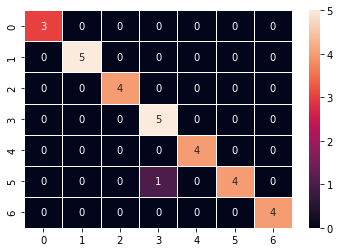

In [17]:
interp_val = ClassificationInterpretation.from_learner(learn, ds_idx=1)
val_cm = interp_val.confusion_matrix()
val_disp = sns.heatmap(val_cm, linewidth=0.5,annot=True)
wandb.log({'val_confusion_matrix': wandb.Image(val_disp.figure)})

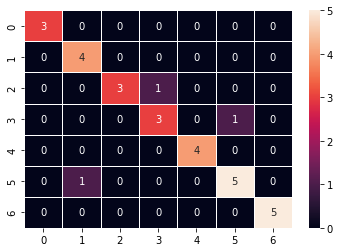

In [18]:
interp_test = ClassificationInterpretation.from_learner(learn, ds_idx=0)
test_cm = interp_test.confusion_matrix()
test_disp = sns.heatmap(test_cm, linewidth=0.5,annot=True)
wandb.log({'test_confusion_matrix': wandb.Image(test_disp.figure)})

In [19]:
wandb.finish()

test_accuracy,0.83333
test_error_rate,0.16667
test_f1_score,0.83063
test_hamming_loss,0.16667
test_loss,0.56333
val_accuracy,0.96667
val_error_rate,0.03333
val_f1_score,0.96633
val_hamming_loss,0.03333
val_loss,0.11362
